# <b>TrackML/HotelRank</b>: Elevating Revenue Performance Through Machine Learning and Deep Learning Techniques.

Revenue management is a very important to make profits in the hotel industry, three main factors play an important role to get it right:  
    <ol>
    <li>Hotel room demand over time (demand forecast).</li>
    <li>Prediction of booking cancellations.</li>
    <li>Online hotel reputation.</li>
    </ol>
In this project we take in account each one thru a linear combination of different scores that represent each item.

# <b>DemandScore</b>: Demand Forecast over 12 months booking.

The objective to section to concentrate ourselves to demand forecast with just Blastness dataset and nothing more:
- We have to clean the data provided and see patterns.
- Detect outliers in the demand
- Compare SARIMAX and prophet neural network to see which fits better for the demandscore.
- Create the demand score for each hotel using booking forecast in next temporal year frame.
- We leave to future work any crossdata about the demand related to weather and external events.


In [1]:
!pip install bamboolib
!pip install pandas numpy seaborn matplot scikit-learn pyarrow prophet statsmodels pycaret datasets 
!python -m bamboolib install_nbextensions

Trying to install bamboolib nbextension...
Could not install bamboolib Jupyter Notebook extension because Jupyter Notebook is not available


As first action we load the csv provided by Blastness and we create a dataset with columns names in English

In [2]:

import glob
import pandas as pd
filelist = glob.glob('./hoteldataset/*.csv')
hotelsbookings = []
column_mapping = {
    'Codice': 'Code',
    'Status': 'Status',
    'Canale': 'BookingChannel',
    'Arrivo': 'Arrival',
    'Partenza': 'Departure',
    'Notti': 'Nights',
    'Totale': 'Total',
    'Data acquisto': 'PurchaseDate',
    'Dispositivo': 'BookingDevice',
    'Data Ultima Modifica/Cancellazione': 'LastModified'
}
for idx,f in enumerate(filelist):
    df = pd.read_csv(f)
    select_columns = list(column_mapping.keys())
    current_df = df[select_columns]
    remap = current_df.rename(columns=column_mapping)
    hotel_id = ""
    if idx < 9:
        hotel_id=f'00{idx+1}'
    else:
        hotel_id=f'0{idx+1}'

    remap['HotelId'] = hotel_id
    hotelsbookings.append(remap)
hotelsbookings[9].head()


/tmp/ipykernel_31877/2239760973.py:18: DtypeWarning: Columns (23,53,62,68,70,81) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_31877/2239760973.py:18: DtypeWarning: Columns (23,52,55,58,59,60,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_31877/2239760973.py:18: DtypeWarning: Columns (23,49,55,59,81,87,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)
/tmp/ipykernel_31877/2239760973.py:18: DtypeWarning: Columns (23,52,53,55,58,59,60,62,68,70,81,89,90,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f)


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId
0,19887PMCMTT6,Cancellata,Sito,23/10/2021,30/10/2021,0,"0,00",31/05/2021,Website,31/05/2021 17:37:31,010
1,19887FBFWGZ7,Confermata,Sito,31/07/2021,06/08/2021,6,"2894,25",08/07/2021,Website,08/07/2021 22:23:51,010
2,19887JIZNTR8,Confermata,Sito,23/10/2021,26/10/2021,3,"2142,00",04/10/2021,Website,04/10/2021 21:24:49,010
3,19887CNIHY10,Confermata,Sito,23/11/2022,28/11/2022,5,"3696,00",01/06/2022,Website,01/06/2022 10:46:15,010
4,19887GOAMJ11,Confermata,Sito,11/10/2022,15/10/2022,4,"4488,00",26/06/2022,Website,26/06/2022 04:14:05,010


Now we merge all hotels in a single dataframe and save to disk. We note that we need to divide cancelled and confirmed booking. Later since we want do forecast on the confirmed.
- Also we need to categorize the origin
- remove the booking device.

First we merge.

In [3]:
# Merge DataFrames
merged_df = pd.concat(hotelsbookings, ignore_index=True)
# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

Merged DataFrame:
                         Code      Status BookingChannel     Arrival  \
0       1400576136/1204413850  Cancellata    Booking.com  22/07/2017   
1       1240874198/1204820657  Cancellata    Booking.com  15/07/2017   
2       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
3       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
4       1656344835/1204828455  Cancellata    Booking.com  22/07/2017   
...                       ...         ...            ...         ...   
151852           19887FIHJR22  Confermata           Sito  19/10/2023   
151853           19887DOSJP23  Confermata           Sito  10/06/2023   
151854           19887KTDJJ24  Confermata           Sito  18/07/2023   
151855           19887LNQHJ25  Confermata           Sito  24/04/2023   
151856           19887IENNC26  Confermata           Sito  18/09/2023   

         Departure  Nights    Total PurchaseDate BookingDevice  \
0       29/07/2017       0     0,00   01/01/2017   

Ok, we've seen a lot of not known or bad data. Just clean it. We want order by date, in descending mode and take only the last 2 years

In [4]:
merged_df.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId
0,1400576136/1204413850,Cancellata,Booking.com,22/07/2017,29/07/2017,0,"0,00",01/01/2017,NaN,01/01/2017 15:27:39,001
1,1240874198/1204820657,Cancellata,Booking.com,15/07/2017,02/08/2017,0,"0,00",01/01/2017,NaN,01/01/2017 23:13:49,001
2,1656344835/1204828455,Cancellata,Booking.com,22/07/2017,09/08/2017,0,"0,00",01/01/2017,NaN,11/01/2017 21:59:16,001
3,1656344835/1204828455,Cancellata,Booking.com,22/07/2017,09/08/2017,0,"0,00",01/01/2017,NaN,10/01/2017 22:10:56,001
4,1656344835/1204828455,Cancellata,Booking.com,22/07/2017,09/08/2017,0,"0,00",01/01/2017,NaN,11/01/2017 21:59:16,001


In [5]:
merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'])
# Sorting by 'Arrival' column in descending order
sorted_bookings_df = merged_df.sort_values(by='Arrival', ascending=False)
# Filtering for HotelId '001'
filtered_df = sorted_bookings_df.loc[sorted_bookings_df['HotelId'] == '010']
filtered_df.head()

/tmp/ipykernel_31877/459522789.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'])


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId
151852,19887FIHJR22,Confermata,Sito,2023-10-19,22/10/2023,3,"3080,00",11/03/2023,Website,11/03/2023 10:15:06,010
151853,19887DOSJP23,Confermata,Sito,2023-10-06,12/06/2023,2,"2112,00",17/03/2023,Website,17/03/2023 17:33:23,010
151849,19887VFAUN19,Confermata,Sito,2023-09-26,28/09/2023,2,"1760,00",02/02/2023,Website,02/02/2023 16:43:04,010
151856,19887IENNC26,Confermata,Sito,2023-09-18,21/09/2023,3,"3168,00",03/06/2023,Website,03/06/2023 12:55:03,010
151850,19887VNOHO20,Confermata,Sito,2023-08-25,27/08/2023,2,"1496,00",09/03/2023,Website,09/03/2023 20:00:03,010


Now I convert datates to timestamps

In [6]:
# Filtering for HotelId '001'
nan_rows = sorted_bookings_df[sorted_bookings_df['Arrival'].isna()]
print("Rows with NaN in 'Arrival':", len(nan_rows))
nan_rows = sorted_bookings_df[sorted_bookings_df['Departure'].isna()]
print("Rows with NaN in 'Departure':", len(nan_rows))
# conversion in datetime
sorted_bookings_df['Arrival'] = pd.to_datetime(sorted_bookings_df['Arrival'], errors='coerce', dayfirst=True)
sorted_bookings_df['Departure'] = pd.to_datetime(sorted_bookings_df['Departure'], errors='coerce', dayfirst=True)
sorted_bookings_df['LastModified'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce', dayfirst=True)
sorted_bookings_df['PurchaseDate'] = pd.to_datetime(sorted_bookings_df['PurchaseDate'], errors='coerce', dayfirst=True)
# we want to make sure that are numerical data
sorted_bookings_df['Total'] = sorted_bookings_df['Total'].str.replace(',', '.').astype(float)
sorted_bookings_df['Total'] = pd.to_numeric(sorted_bookings_df['Total'])
sorted_bookings_df['Nights'] = pd.to_numeric(sorted_bookings_df['Nights'])
# add timestamp
sorted_bookings_df['Arrival_Timestamp'] = sorted_bookings_df['Arrival'].astype('int64')
sorted_bookings_df['Departure_Timestamp'] = sorted_bookings_df['Departure'].astype('int64')
sorted_bookings_df['LastModified_Timestamp'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce')
sorted_bookings_df['Purchase_Timestamp'] = sorted_bookings_df['PurchaseDate'].astype('int64')
sorted_bookings_df.head()



Rows with NaN in 'Arrival': 0
Rows with NaN in 'Departure': 0


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp
60363,16134HN15330,Confermata,Sito,2024-11-02,2024-02-18,7,3208.0,2023-03-22,Website,2023-03-22 23:03:58,006,1730505600000000000,1708214400000000000,2023-03-22 23:03:58,1679443200000000000
60681,3379360609/4257615568,Confermata,Booking.com,2024-10-02,2024-02-17,7,5130.0,2023-05-20,NaN,2023-05-20 10:06:11,006,1727827200000000000,1708128000000000000,2023-05-20 10:06:11,1684540800000000000
60413,2640244691/4170868985,Confermata,Booking.com,2024-10-02,2024-02-17,7,4887.0,2023-04-01,NaN,2023-04-01 14:27:37,006,1727827200000000000,1708128000000000000,2023-04-01 14:27:37,1680307200000000000
60411,2641625582/4170854126,Confermata,Booking.com,2024-10-02,2024-02-17,7,1968.3,2023-04-01,NaN,2023-04-01 14:17:14,006,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000
60410,2641625582/4170854114,Confermata,Booking.com,2024-10-02,2024-02-17,7,1871.1,2023-04-01,NaN,2023-04-01 14:17:14,006,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000


We want to add the city to he dataset the client has provided the following mapping:
```
hotel_to_city = {
    '001': "Rome, Italu",
    '002': "Naples, Italy",
    '003': "Florence, Italy",
    '004': "Florence, Italy",
    '005': "Naples, Italy",
    '006': "Brindisi, Italy",
    '007': "Latina, Italy",
    '008': "Olbia, Sardinia, Italy",
    '009': "Chamonix-Mont-Blanc, France",
    '010': "Rome, Italy",
}
```
So we can have a complete a dataset to correlate in future with events, weather and so on.

In [7]:
coordinate_to_city = {
    '001': "Rome",
    '002': "Naples",
    '003': "Florence",
    '004': "Florence",
    '005': "Naples",
    '006': "Brindisi",
    '007': "Latina",
    '008': "Olbia",
    '009': "Chamonix-Mont-Blanc",
    '010': "Rome",
}

# Function to get the city name based on HotelId
def get_city(hotel_id):
    return coordinate_to_city.get(hotel_id, "Unknown")

# Add the City column based on the HotelId
sorted_bookings_df['City'] = sorted_bookings_df['HotelId'].apply(get_city)

We want also add the season because we know from the domain the booking changes of season and when the booking device is not known.

In [8]:
# we clean unknown
sorted_bookings_df['BookingDevice'].fillna('Unknown', inplace=True)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
sorted_bookings_df['Season'] = sorted_bookings_df['Arrival'].apply(get_season)
sorted_bookings_df.head()



,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60363,16134HN15330,Confermata,Sito,2024-11-02,2024-02-18,7,3208.0,2023-03-22,Website,2023-03-22 23:03:58,006,1730505600000000000,1708214400000000000,2023-03-22 23:03:58,1679443200000000000,Brindisi,Fall
60681,3379360609/4257615568,Confermata,Booking.com,2024-10-02,2024-02-17,7,5130.0,2023-05-20,Unknown,2023-05-20 10:06:11,006,1727827200000000000,1708128000000000000,2023-05-20 10:06:11,1684540800000000000,Brindisi,Fall
60413,2640244691/4170868985,Confermata,Booking.com,2024-10-02,2024-02-17,7,4887.0,2023-04-01,Unknown,2023-04-01 14:27:37,006,1727827200000000000,1708128000000000000,2023-04-01 14:27:37,1680307200000000000,Brindisi,Fall
60411,2641625582/4170854126,Confermata,Booking.com,2024-10-02,2024-02-17,7,1968.3,2023-04-01,Unknown,2023-04-01 14:17:14,006,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Brindisi,Fall
60410,2641625582/4170854114,Confermata,Booking.com,2024-10-02,2024-02-17,7,1871.1,2023-04-01,Unknown,2023-04-01 14:17:14,006,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Brindisi,Fall


Now before going further and doing descriptive statistics we neeed to know is there are still NaN. It is ok we store for future purposes the dataset in parquet file. 

In [9]:
# Check if any row in any column is NaN
has_nan = sorted_bookings_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
# Display rows with any NaN values
rows_with_nan = sorted_bookings_df[sorted_bookings_df.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan.head()


Does the DataFrame contain any NaN values? True
Rows with NaN values:


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
44934,RDK00025294-SE,Cancellata,NaN,2023-12-07,2023-07-15,0,0.00,2023-06-25,Unknown,2023-06-25 18:42:22,005,1701907200000000000,1689379200000000000,2023-06-25 18:42:22,1687651200000000000,Naples,Winter
44933,RDK00025294-SE,Confermata,NaN,2023-12-07,2023-07-15,3,656.64,2023-06-25,Unknown,2023-06-25 18:42:22,005,1701907200000000000,1689379200000000000,2023-06-25 18:42:22,1687651200000000000,Naples,Winter
44385,RDK00014771-A35343-25660-13565848-Secret Escapes,Confermata,NaN,2023-12-05,2023-05-17,5,1257.22,2023-04-12,Unknown,2023-04-12 15:58:19,005,1701734400000000000,1684281600000000000,2023-04-12 15:58:19,1681257600000000000,Naples,Winter
44366,RDK00014459-A35343-21410-13541714-Secret Escapes,Cancellata,NaN,2023-12-05,2023-05-13,0,0.00,2023-04-10,Unknown,2023-04-10 19:52:26,005,1701734400000000000,1683936000000000000,2023-04-10 19:52:26,1681084800000000000,Naples,Winter
44365,RDK00014459-A35343-21410-13541714-Secret Escapes,Confermata,NaN,2023-12-05,2023-05-13,1,199.68,2023-04-10,Unknown,2023-04-10 19:52:26,005,1701734400000000000,1683936000000000000,2023-04-10 19:52:26,1681084800000000000,Naples,Winter


Ok. We've seen that the booking channel can be a valid string or Unknown. The other thing that we want is to the hotel booking for a fixed period from 2024 to 2022. After this we can 

In [10]:
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].fillna('Unknown')
sorted_bookings_df.head()


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60363,16134HN15330,Confermata,Sito,2024-11-02,2024-02-18,7,3208.0,2023-03-22,Website,2023-03-22 23:03:58,006,1730505600000000000,1708214400000000000,2023-03-22 23:03:58,1679443200000000000,Brindisi,Fall
60681,3379360609/4257615568,Confermata,Booking.com,2024-10-02,2024-02-17,7,5130.0,2023-05-20,Unknown,2023-05-20 10:06:11,006,1727827200000000000,1708128000000000000,2023-05-20 10:06:11,1684540800000000000,Brindisi,Fall
60413,2640244691/4170868985,Confermata,Booking.com,2024-10-02,2024-02-17,7,4887.0,2023-04-01,Unknown,2023-04-01 14:27:37,006,1727827200000000000,1708128000000000000,2023-04-01 14:27:37,1680307200000000000,Brindisi,Fall
60411,2641625582/4170854126,Confermata,Booking.com,2024-10-02,2024-02-17,7,1968.3,2023-04-01,Unknown,2023-04-01 14:17:14,006,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Brindisi,Fall
60410,2641625582/4170854114,Confermata,Booking.com,2024-10-02,2024-02-17,7,1871.1,2023-04-01,Unknown,2023-04-01 14:17:14,006,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Brindisi,Fall


Now I want to restrict the timing interval between 2020 and 2024.

In [11]:
start_date = '2020-01-01'
end_date = '2024-02-28'
sorted_bookings_df.head()
datetime_columns = ['Arrival', 'Departure', 'PurchaseDate', 'LastModified']
for col in datetime_columns:
    sorted_bookings_df[col] = pd.to_datetime(sorted_bookings_df[col])
hb_dataset = sorted_bookings_df[(sorted_bookings_df['Arrival'] >= start_date) & (sorted_bookings_df['Arrival'] <= end_date)] 
# Check if any row in any column is NaN
has_nan = hb_dataset.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
if has_nan:
# Display rows with any NaN values
    rows_with_nan = hb_dataset[hb_dataset.isna().any(axis=1)]
    print("Rows with NaN values:")
    rows_with_nan.head()
else:
    print('The dataset is ready some descriptivre statistics')

Does the DataFrame contain any NaN values? False
The dataset is ready some descriptivre statistics


In [12]:
# Save the filtered DataFrame to a Parquet file
parquet_file = 'filtered_data.parquet'
hb_dataset.to_parquet(parquet_file)
print(f"Filtered DataFrame saved to {parquet_file}")

Filtered DataFrame saved to filtered_data.parquet


In [13]:
hb_dataset.head(10)

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60596,2708236755/4234197239,Confermata,Booking.com,2024-02-24,2024-03-02,7,3134.70,2023-05-07,Unknown,2023-05-07 09:39:59,006,1708732800000000000,1709337600000000000,2023-05-07 09:39:59,1683417600000000000,Brindisi,Winter
60595,2366509110/4234190518,Cancellata,Booking.com,2024-02-24,2024-03-02,0,0.00,2023-05-07,Unknown,2023-05-07 09:33:58,006,1708732800000000000,1709337600000000000,2023-05-07 09:33:58,1683417600000000000,Brindisi,Winter
60341,2340590757/4148039829,Cancellata,Booking.com,2024-02-17,2024-02-24,0,0.00,2023-03-19,Unknown,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter
60340,2340590757/4148039863,Cancellata,Booking.com,2024-02-17,2024-02-24,0,0.00,2023-03-19,Unknown,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter
60339,2340590757/4148039844,Cancellata,Booking.com,2024-02-17,2024-02-24,0,0.00,2023-03-19,Unknown,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter
60269,16134FG15230,Confermata,Sito,2024-02-17,2024-02-24,7,3507.00,2023-03-07,Website,2023-03-07 21:29:22,006,1708128000000000000,1708732800000000000,2023-03-07 21:29:22,1678147200000000000,Brindisi,Winter
60417,3051523557/4172280874,Confermata,Booking.com,2024-02-03,2024-03-08,6,2515.05,2023-04-02,Unknown,2023-04-02 11:34:34,006,1706918400000000000,1709856000000000000,2023-04-02 11:34:34,1680393600000000000,Brindisi,Winter
60313,2771190332/4142120223,Cancellata,Booking.com,2024-02-01,2024-01-07,0,0.00,2023-03-15,Unknown,2023-03-15 18:50:09,006,1706745600000000000,1704585600000000000,2023-03-15 18:50:09,1678838400000000000,Brindisi,Winter
60312,2722531194/4142090827,Cancellata,Booking.com,2024-02-01,2024-01-07,0,0.00,2023-03-15,Unknown,2023-03-15 18:31:58,006,1706745600000000000,1704585600000000000,2023-03-15 18:31:58,1678838400000000000,Brindisi,Winter
60314,2771190332/4142120207,Cancellata,Booking.com,2024-02-01,2024-01-07,0,0.00,2023-03-15,Unknown,2023-03-15 18:50:09,006,1706745600000000000,1704585600000000000,2023-03-15 18:50:09,1678838400000000000,Brindisi,Winter


 Here we start to to understand the categories Status and Booking devices and use an Ordinal encoder. Our expectation is for the status are the categories: Confermata(Confirmed), Cancellata(Cancelled), Modificata(Modified). This later will be useful for cancellation score.

In [14]:
hb_dataset['Status'].unique()

array(['Confermata', 'Cancellata', 'Modificata'], dtype=object)

In [15]:
hb_dataset['BookingDevice'].unique()

array(['Unknown', 'Website', 'Mobile', 'Tablet'], dtype=object)

In [16]:
from sklearn.preprocessing import OrdinalEncoder
status_categories = hb_dataset[['Status']]
device_categories = hb_dataset[['BookingDevice']]
ordinal_encoder = OrdinalEncoder()
hb_dataset_booking_cat = ordinal_encoder.fit_transform(status_categories)
hb_dataset_booking_device = ordinal_encoder.fit_transform(device_categories)
hb_dataset['Status'] = hb_dataset_booking_cat
hb_dataset['BookingDevice'] = hb_dataset_booking_device
hb_dataset.head(10)

/tmp/ipykernel_31877/699959253.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hb_dataset['Status'] = hb_dataset_booking_cat
/tmp/ipykernel_31877/699959253.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hb_dataset['BookingDevice'] = hb_dataset_booking_device


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
60596,2708236755/4234197239,1.0,Booking.com,2024-02-24,2024-03-02,7,3134.70,2023-05-07,2.0,2023-05-07 09:39:59,006,1708732800000000000,1709337600000000000,2023-05-07 09:39:59,1683417600000000000,Brindisi,Winter
60595,2366509110/4234190518,0.0,Booking.com,2024-02-24,2024-03-02,0,0.00,2023-05-07,2.0,2023-05-07 09:33:58,006,1708732800000000000,1709337600000000000,2023-05-07 09:33:58,1683417600000000000,Brindisi,Winter
60341,2340590757/4148039829,0.0,Booking.com,2024-02-17,2024-02-24,0,0.00,2023-03-19,2.0,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter
60340,2340590757/4148039863,0.0,Booking.com,2024-02-17,2024-02-24,0,0.00,2023-03-19,2.0,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter
60339,2340590757/4148039844,0.0,Booking.com,2024-02-17,2024-02-24,0,0.00,2023-03-19,2.0,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter
60269,16134FG15230,1.0,Sito,2024-02-17,2024-02-24,7,3507.00,2023-03-07,3.0,2023-03-07 21:29:22,006,1708128000000000000,1708732800000000000,2023-03-07 21:29:22,1678147200000000000,Brindisi,Winter
60417,3051523557/4172280874,1.0,Booking.com,2024-02-03,2024-03-08,6,2515.05,2023-04-02,2.0,2023-04-02 11:34:34,006,1706918400000000000,1709856000000000000,2023-04-02 11:34:34,1680393600000000000,Brindisi,Winter
60313,2771190332/4142120223,0.0,Booking.com,2024-02-01,2024-01-07,0,0.00,2023-03-15,2.0,2023-03-15 18:50:09,006,1706745600000000000,1704585600000000000,2023-03-15 18:50:09,1678838400000000000,Brindisi,Winter
60312,2722531194/4142090827,0.0,Booking.com,2024-02-01,2024-01-07,0,0.00,2023-03-15,2.0,2023-03-15 18:31:58,006,1706745600000000000,1704585600000000000,2023-03-15 18:31:58,1678838400000000000,Brindisi,Winter
60314,2771190332/4142120207,0.0,Booking.com,2024-02-01,2024-01-07,0,0.00,2023-03-15,2.0,2023-03-15 18:50:09,006,1706745600000000000,1704585600000000000,2023-03-15 18:50:09,1678838400000000000,Brindisi,Winter


## Descriptive statistics

In [22]:
# For numeric columns only
descriptive_stats = hb_dataset.describe()
print("\nDescriptive Statistics for numeric columns in the filtered DataFrame:")
print(descriptive_stats)
descriptive_stats_all = hb_dataset.describe(include='all')
print("\nDescriptive Statistics for all columns in the filtered DataFrame:")
print(descriptive_stats_all)


Descriptive Statistics for numeric columns in the filtered DataFrame:
             Status        Nights         Total  BookingDevice  \
count  39375.000000  39375.000000  39375.000000   39375.000000   
mean       0.589486      1.517663    396.484267       2.041549   
std        0.525435      1.969103    668.298718       0.519445   
min        0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      0.000000       2.000000   
50%        1.000000      1.000000    144.900000       2.000000   
75%        1.000000      2.000000    531.515000       2.000000   
max        2.000000     30.000000  20124.000000       3.000000   

       Arrival_Timestamp  Departure_Timestamp  Purchase_Timestamp  
count       3.937500e+04         3.937500e+04        3.937500e+04  
mean        1.641716e+18         1.642539e+18        1.636303e+18  
std         3.285898e+16         3.243173e+16        3.340110e+16  
min         1.577837e+18         1.577923e+18        1.553213e

/tmp/ipykernel_31877/2572938487.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_dataset.describe(include='all')
/tmp/ipykernel_31877/2572938487.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all = hb_dataset.describe(include='all')
/tmp/ipykernel_31877/2572938487.py:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  descriptive_stats_all

We know that:
- We've 39375 booking in the period.
- The average staying is 1.6 days for each booking.
- The medium booking revenue is 370 euros.

That's not enough, we want to know:
- How frequent is a booking?
- Which between our customers how had most revenue?
- Which has most room booked and and in which city?
- Which is the season in which we've most rooom booked? 

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

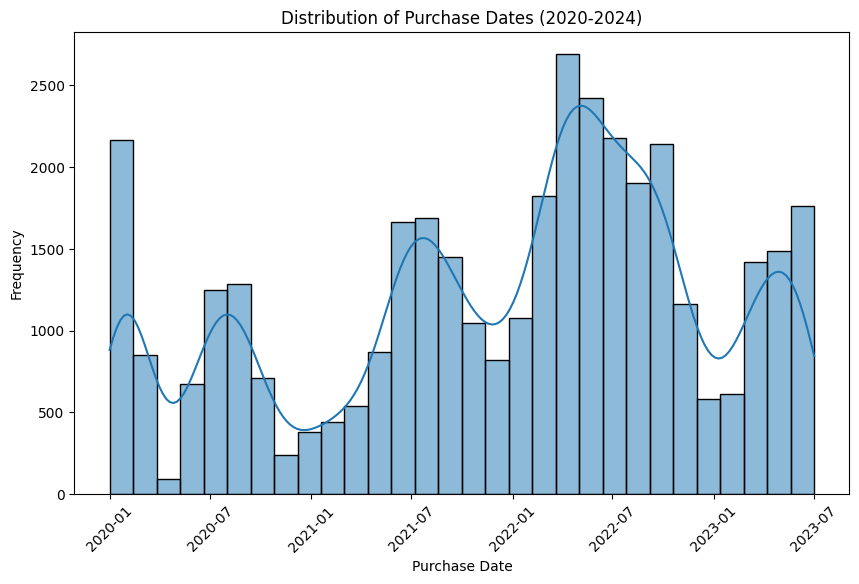

In [25]:
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_df = hb_dataset[(hb_dataset['PurchaseDate'] >= start_date) & (hb_dataset['PurchaseDate'] <= end_date)]

# Plot the distribution of purchase dates using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['PurchaseDate'], kde=True, bins=30)
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Dates (2020-2024)')
plt.xticks(rotation=45)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['Arrival'], kde=True, bins=30)
plt.xlabel('Arrival Date')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Dates (2020-2024)')
plt.xticks(rotation=45)
plt.show()

Make sense. Most booking are at the beginning of the year and just before summer. Italians tends to go in vacation on August so in July the book.

In [ ]:
# Convert 'PurchaseDate' to ordinal for fitting distributions
purchase_dates = hb_dataset['PurchaseDate'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(purchase_dates)
    ks_stat, p_value = stats.kstest(purchase_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(purchase_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(purchase_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(purchase_dates), max(purchase_dates), 1000)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Purchase Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Purchase Dates')
plt.legend()
plt.show()


In [ ]:
arrival_dates = hb_dataset['Arrival'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(arrival_dates)
    ks_stat, p_value = stats.kstest(arrival_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(arrival_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(arrival_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(arrival_dates), max(arrival_dates), 1000)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Arrival Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Arrival Dates')
plt.legend()
plt.show()

## Which between our customers had most revenue?

In [ ]:

revenue_per_hotel = hb_dataset.groupby(['HotelId', 'City'])['Total'].sum().reset_index()
revenue_per_hotel.sort_values(['Total'], inplace=True, ascending=False)
revenue_per_hotel.head()


In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='HotelId', y='Total', data=revenue_per_hotel)
plt.xlabel('Hotel ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Hotel (2020-2024)')
plt.show()

Now we want to see in the dataset the correlation between data, but for doing this and reaching the correlation matrix we need to reduce the 
features, distiguish between categorical and numerical and doing one shot encoding, removing redundant features.

In [ ]:

# Identify numerical and categorical columns
numerical_cols = hb_dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = hb_dataset.select_dtypes(include=['object']).columns
# Drop unnecessary columns
corr_df = hb_dataset.drop(columns=['Code', 'Arrival', 'Departure', 'PurchaseDate', 'LastModified'])
# One-hot encoding of categorical columns using pd.get_dummies
df_encoded = pd.get_dummies(corr_df, drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

As expected some things are evident:
- Rome is the city with higher possible revenue having an high correlation with Price.
- Purchase Date and Arrival Date are correlated.
Less evident is the behaviour for Season and the cities:
- Expected behaviour that Olbia is overcrowded in Summer, since it is in Sardinia. 
For our purpose, compute demandscore is enough since we select just Arrival and treat the dataset like a time series.
Now we will focus in model selection based on Arrival since our goal is to compute the demand score per hotel.
There are two algorithms:
    - Prophet
    -  SARIMAX

We'll see which is the best one for this dataset and we compute the score but first we need to detect anomalies for time series. Before we need to see if data contains anomalies and treat them. We aggregate the data weekly.


In [47]:
hb_dataset.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season,Week
60596,2708236755/4234197239,1.0,Booking.com,2024-02-24,2024-03-02,7,3134.7,2023-05-07,2.0,2023-05-07 09:39:59,006,1708732800000000000,1709337600000000000,2023-05-07 09:39:59,1683417600000000000,Brindisi,Winter,2024-02-19
60595,2366509110/4234190518,0.0,Booking.com,2024-02-24,2024-03-02,0,0.0,2023-05-07,2.0,2023-05-07 09:33:58,006,1708732800000000000,1709337600000000000,2023-05-07 09:33:58,1683417600000000000,Brindisi,Winter,2024-02-19
60341,2340590757/4148039829,0.0,Booking.com,2024-02-17,2024-02-24,0,0.0,2023-03-19,2.0,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter,2024-02-12
60340,2340590757/4148039863,0.0,Booking.com,2024-02-17,2024-02-24,0,0.0,2023-03-19,2.0,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter,2024-02-12
60339,2340590757/4148039844,0.0,Booking.com,2024-02-17,2024-02-24,0,0.0,2023-03-19,2.0,2023-03-19 10:37:54,006,1708128000000000000,1708732800000000000,2023-03-19 10:37:54,1679184000000000000,Brindisi,Winter,2024-02-12


In [65]:
# Aggregate the data to get weekly demand
hb_dataset['Week'] = hb_dataset['Arrival'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_demand = hb_dataset.groupby(['HotelId','Week']).size().reset_index(name='BookingCount')
weekly_demand.sort_values(by='Week')
weekly_demand.head()

/tmp/ipykernel_31877/2936684913.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,HotelId,Week,BookingCount
0,001,2020-01-06,5
1,001,2020-03-02,2
2,001,2020-04-06,1
3,001,2020-05-18,2
4,001,2020-05-25,1


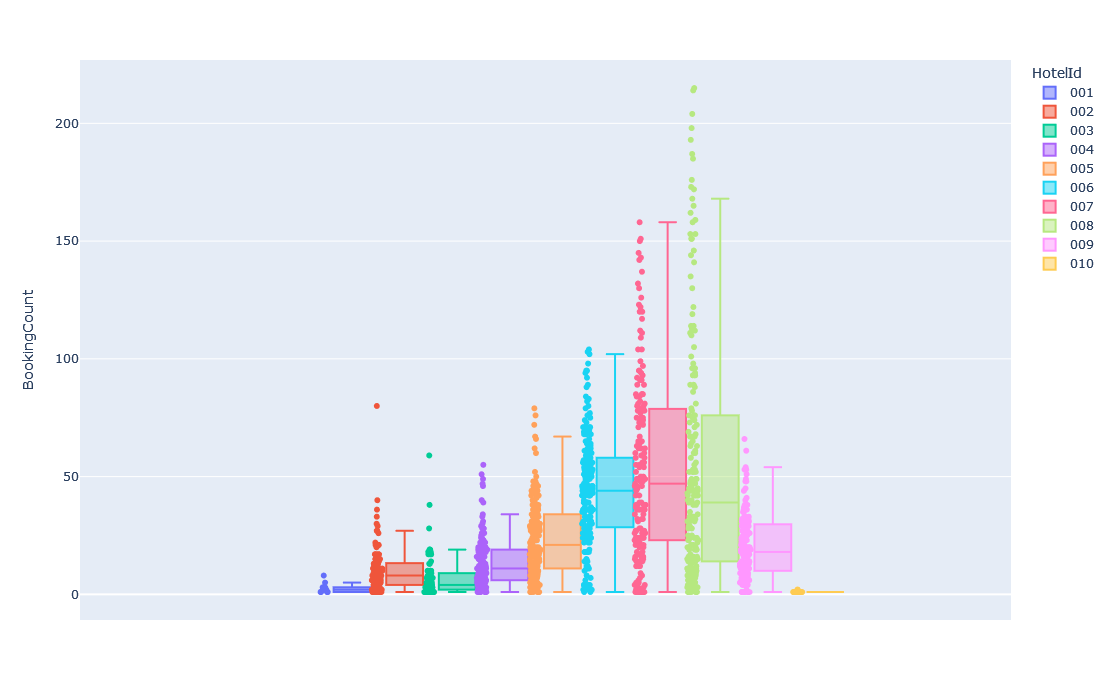

In [68]:

import plotly.express as px
fig = px.box(weekly_demand, y="BookingCount", color='HotelId', points='all')
fig.update_traces(quartilemethod="linear")
fig.update_layout(
    width=1000,  
    height=700
)
fig.show()


We use this diagram to assist with interpreting the boxplot:  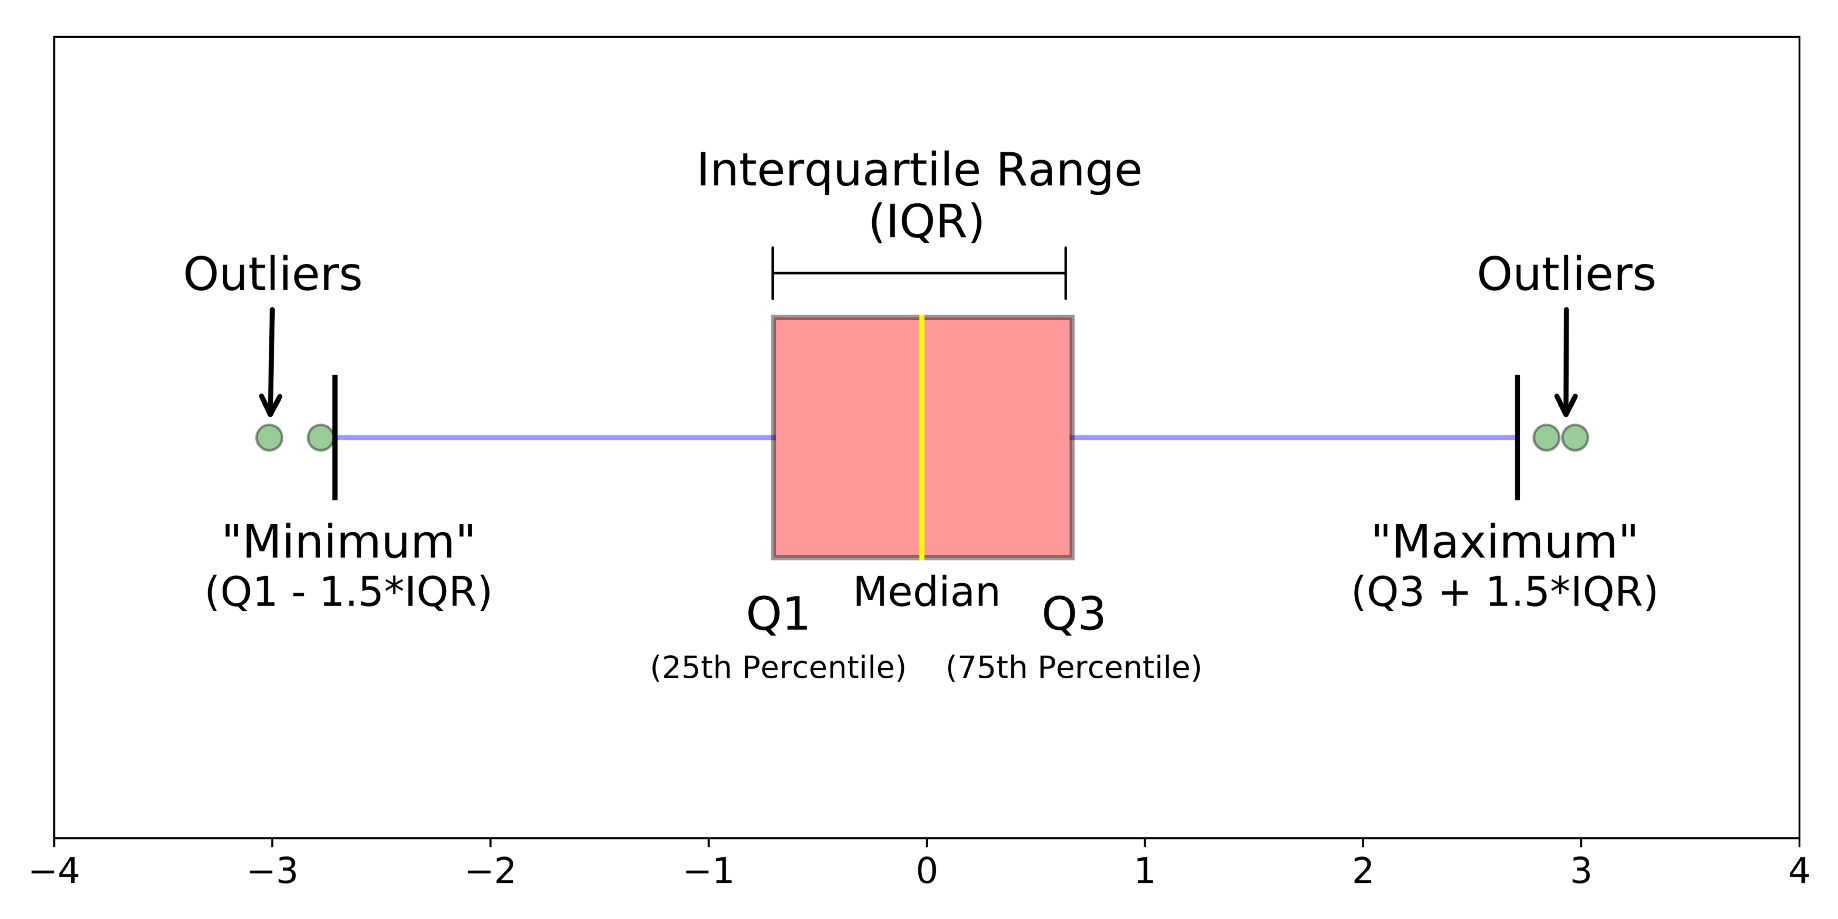 This come from the bloog [Towards Data Science](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd5)
So using that model, there are hotel that have values that are candidate outliers in the time series distribution. Let's try to isolate the box plot and the booking per week per hotel.

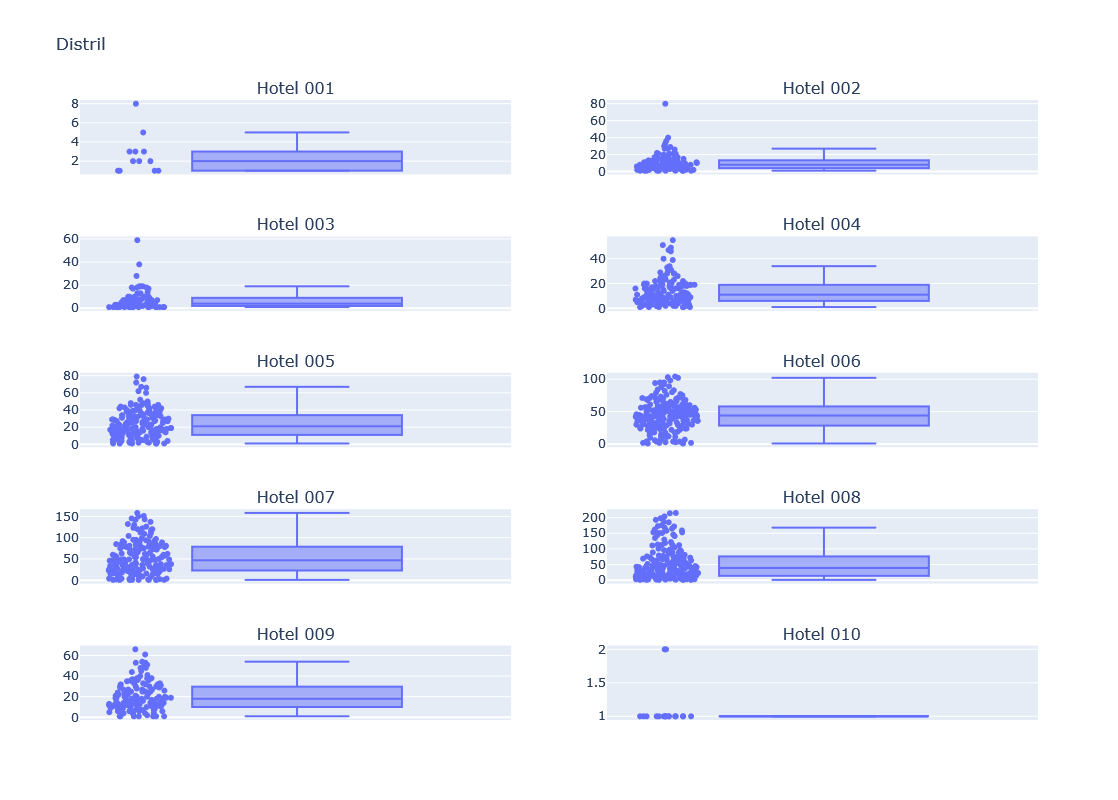

In [84]:

import plotly.express as px

hotel_ids = weekly_demand['HotelId'].unique()
rows = (len(hotel_ids) + 1) // 2  # Calculate the number of rows needed
fig = make_subplots(rows=rows, cols=2, subplot_titles=[f'Hotel {hotel_id}' for hotel_id in hotel_ids])
for idx, hotel_id in enumerate(hotel_ids):
    hotel_data = weekly_demand[weekly_demand['HotelId'] == hotel_id]    
    box_plot = px.box(hotel_data, y="BookingCount", points='all')
    for trace in box_plot['data']:
        fig.add_trace(trace, row=(idx // 2) + 1, col=(idx % 2) + 1)
fig.update_layout(height=800, width=1000, showlegend=False, title_text="Distril")
fig.show()


The comprensive set of boxplot indicates that in each hotel there weeks that we've exceptional demand i.e. in Summer for each Hotel or it can be anomalies 
to be detected. We use an algorithm that comes a well known Italian university but at the moment let's understand seasonal decomposition. We pick up HotelId 008, since looks one that have most anomalies. 

## Seasonal Decomposition
Seasonal decompositon will fundamental for our algorithm. In this [decomposition](https://math.unm.edu/~lil/Stat581/6-decomposition.pdf) a time series is split on three parts:
1. Trend: Long term pattern present in the series both increase or decrease.
2. Seasonal: Repeating cyclic pattern in the series where the cycle is specified in weeks, months, years.
3. Residual: Basically noise. It is the remaining part of the data after removing the trend and seasonal components.

We want to understand whether each time series is additive or multiplicative. To do this, we can use seasonal_decompose, which provides us with three separate components: trend, seasonality, and residual. If the seasonality component changes proportionally with the trend, we classify the time series as multiplicative. Otherwise, if the seasonality remains constant regardless of the trend, it is considered additive.

In our context, a hotel that experiences a fixed summer peak of 20 additional rooms fits an additive model. On the other hand, a hotel that sees a 20% increase in bookings every summer would better fit a multiplicative time series.
                                      - 

In [100]:
import plotly.graph_objs as go
import statsmodels.api as sm
hotel_data = weekly_demand[weekly_demand['HotelId'] == '008']    


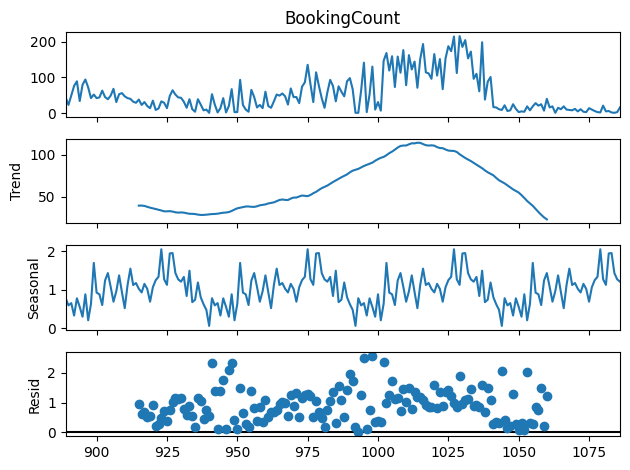

In [95]:
res = sm.tsa.seasonal_decompose(hotel_data['BookingCount'].interpolate(),
                                period=52,
                                model='multiplicative')
resplot = res.plot()

In [96]:
res.resid[np.isfinite(res.resid) == False] = 0

In [97]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                period=52,
                                model='additive')

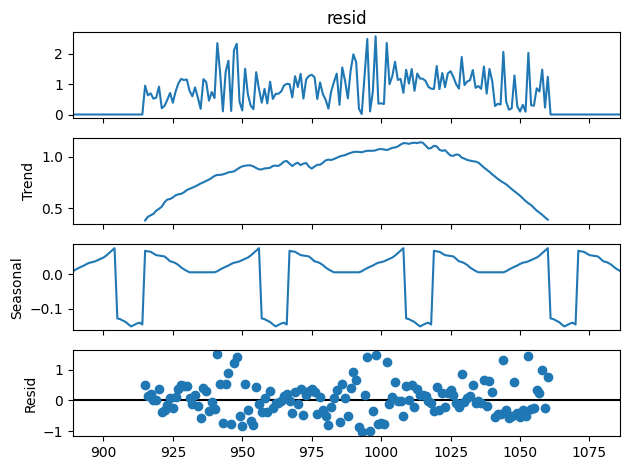

In [98]:
resplot = res_resid.plot()

## Anomaly detection.
An anomaly in a time series refers to a data point or sequence of data points that significantly deviates from the expected patterns or trends typically observed in the data. These anomalies can manifest in various ways, such as abrupt changes in values, an increase in NULL values, missing data segments, or other irregular patterns that deviate from normal fluctuations. As discussed in [Anomaly Detection in Time Series: A Comprehensive Evaluation](https://www.vldb.org/pvldb/vol15/p1779-wenig.pdf), such anomalies can indicate significant events or issues within the system being analyzed. In our specific context, an anomaly might suggest that during certain periods, the demand exceeded the hotel's operational capacity.
Numerous techniques for anomaly detection have been evaluated in the literature. During our research, we identified an effective algorithm that can be applied to the residual component of a seasonal-trend decomposition, utilizing the Isolation Forest method. This approach is both efficient and fast. We propose this algorithm for anomaly detection at each hotel level, as inspired by the work on [Unsupervised Anomaly Detection on Server Metrics](https://webthesis.biblio.polito.it/21240/1/tesi.pdf).

#### Anomaly detection with Isolation Forest
The steps of the algorithm are:
1. Normalization of the time series
2. Seasonal trend decomposition of the time series to extract the residual.
3. Applying ISOLATION FOREST to the residual
4. Remove points not considered anomalous by the Isolation Forest
5. Apply DBSCAN to the points outside the confidence region to obtain clusters of points close to each other
6. Points that do not belong to any cluster are the anomalies

[Isolation Forest](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8888179) algorithm directly seeks anomalous points based on the contamination parameter. First, the algorithm builds a forest of random decision trees. After training, it assigns an anomaly score to each data point. At this stage, we don't know whether a point is an inlier or outlier. The contamination parameter serves as a threshold, determining how many points are classified as outliers by converting these raw scores into inlier or outlier labels.

In [83]:
!pip install matplot statsmodels numpy

### Normalization of time series
We pick up Hotel08 since from the boxplot has more parameters above

### Seasonal-Trend decomposition using LOESS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Apply STL decomposition
stl = STL(df['Value'], seasonal=13)
result = stl.fit()

# Extract the residual
residual = result.resid

# Plot the decomposition results
result.plot()
plt.show()



In [ ]:
# Plot the decomposition results
result.plot()
plt.show()

# Plot residual component
plt.figure()
plt.plot(residual)
plt.title("Residual Component")
plt.show()


In [ ]:
iso_forest = IsolationForest(contamination=0.05)  # Adjust contamination as needed
df['anomaly_score'] = iso_forest.fit_predict(residual.values.reshape(-1, 1)]
df['is_anomaly'] = df['anomaly_score'] == -1
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Value'], label='Time Series')
plt.scatter(df.index[df['is_anomaly']], df['Value'][df['is_anomaly']], color='red', label='Anomalies')
plt.title('Time Series with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()
# Plot the residual with anomalies marked
plt.figure(figsize=(10, 6))
plt.plot(df.index, residual, label='Residual')
plt.scatter(df.index[df['is_anomaly']], residual[df['is_anomaly']], color='red', label='Anomalies')
plt.title('Residual with Anomalies Detected by Isolation Forest')
plt.legend()
plt.show()

In [ ]:
Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
Normalization can be useful, and even required in some machine learning algorithms when your time series data has input values with differing scales.It may be required for algorithms, like k-Nearest neighbors, which uses distance calculations and Linear Regression and Artificial Neural Networks that weight input values.
Normalization requires that you know or are able to accurately estimate the minimum and maximum observable values. You may be able to estimate these values from your available data. If your time series is trending up or down, estimating these expected values may be difficult and normalization may not be the best method to use on your problem.

A value is normalized as follows:
y = (x - min) / (max - min)

Where the minimum and maximum values pertain to the value x being normalized.

For example, for the temperature data, we could guesstimate the min and max observable values as 30 and -10, which are greatly over and under-estimated. We can then normalize any value like 18.8 as follows:
y = (x - min) / (max - min)
y = (18.8 - -10) / (30 - -10)
y = 28.8 / 40
y = 0.72

You can see that if an x value is provided that is outside the bounds of the minimum and maximum values, that the resulting value will not be in the range of 0 and 1. You could check for these observations prior to making predictions and either remove them from the dataset or limit them to the pre-defined maximum or minimum values.

You can normalize your dataset using the scikit-learn object MinMaxScaler.

Good practice usage with the MinMaxScaler and other rescaling techniques is as follows:

    Fit the scaler using available training data. For normalization, this means the training data will be used to estimate the minimum and maximum observable values. This is done by calling the fit() function,
    Apply the scale to training data. This means you can use the normalized data to train your model. This is done by calling the transform() function
    Apply the scale to data going forward. This means you can prepare new data in the future on which you want to make predictions.

If needed, the transform can be inverted. This is useful for converting predictions back into their original scale for reporting or plotting. This can be done by calling the inverse_transform() function.

Below is an example of normalizing the Minimum Daily Temperatures dataset.

The scaler requires data to be provided as a matrix of rows and columns. The loaded time series data is loaded as a Pandas Series. It must then be reshaped into a matrix of one column with 3,650 rows.

The reshaped dataset is then used to fit the scaler, the dataset is normalized, then the normalization transform is inverted to show the original values again.
# Normalize time series data
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
# load the dataset and print the first 5 rows
series = read_csv('daily-minimum-temperatures-in-me.csv', header=0, index_col=0)
print(series.head())
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print the first 5 rows
normalized = scaler.transform(values)
for i in range(5):
 print(normalized[i])
# inverse transform and print the first 5 rows
inversed = scaler.inverse_transform(normalized)
for i in range(5):
 print(inversed[i])

Running the example prints the first 5 rows from the loaded dataset, shows the same 5 values in their normalized form, then the values back in their original scale using the inverse transform.

We can also see that the minimum and maximum values of the dataset are 0 and 26.3 respectively.
Date
1981-01-01 20.7
1981-01-02 17.9
1981-01-03 18.8
1981-01-04 14.6
1981-01-05 15.8
Name: Temp, dtype: float64
Min: 0.000000, Max: 26.300000
[ 0.78707224]
[ 0.68060837]
[ 0.7148289]
[ 0.55513308]
[ 0.60076046]
[ 20.7]
[ 17.9]
[ 18.8]
[ 14.6]
[ 15.8]

There is another type of rescaling that is more robust to new values being outside the range of expected values; this is called Standardization. We will look at that next.

In [ ]:
 STL uses LOESS (locally estimated scatterplot smoothing) to extract smooths estimates of the three components. The key inputs into STL are:

    season - The length of the seasonal smoother. Must be odd.

    trend - The length of the trend smoother, usually around 150% of season. Must be odd and larger than season.

    low_pass - The length of the low-pass estimation window, usually the smallest odd number larger than the periodicity of the data.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style("darkgrid")

In [ ]:
Computing STL and ploting

In [ ]:
mod = STL(y, period=period, seasonal=seasonal)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)
# Extract the residual
residual = result.resid

# Plot the decomposition results
result.plot()
plt.show()

# Plot residual component
plt.figure()
plt.plot(residual)
plt.title("Residual Component")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


# Aggregate the data to get weekly demand
hb_dataset['Week'] = hb_dataset['Arrival'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_demand = hb_dataset.groupby('Week').size().reset_index(name='Demand')
weekly_demand.head()




In [ ]:

# Prepare the data for Prophet
weekly_demand_prophet = weekly_demand.rename(columns={'Week': 'ds', 'Demand': 'y'})

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(weekly_demand_prophet)

# Make a future dataframe for Prophet
future_prophet = prophet_model.make_future_dataframe(periods=52, freq='W')
forecast_prophet = prophet_model.predict(future_prophet)



In [ ]:
weekly_demand_prophet.head()

In [ ]:
forecast_prophet.head()

In [ ]:
# Fit ARIMA model
arima_model = SARIMAX(weekly_demand['Demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_model_fit = arima_model.fit(disp=False)
# Forecast using ARIMA
forecast_arima = arima_model_fit.get_forecast(steps=52)
forecast_arima_df = forecast_arima.summary_frame()


In [ ]:
# Prepare the forecast data for comparison
forecast_prophet = forecast_prophet[['ds', 'yhat']].set_index('ds')
forecast_arima_df = forecast_arima_df[['mean']]


# Performance
Better SARIMA. So we will use SARIMA for the compute of the score based on arrival. Let's motivate the process:
- Mean Average Error (MSE): Tells us the average magnitude of the forecast errors. 
- Mean Square Error: Emphasizes larger errors more than MAE. 
- Root Mean Square Error: Provides an error measure in the same units as the demand. 

## Comparing Models
- SARIMA shows an higher MAE than Prophet but perform better since MSE and RMSE are lower.


In [ ]:

# Compute evaluation metrics
# For Prophet
prophet_true = weekly_demand['Demand'].values[-52:]
prophet_pred = forecast_prophet['yhat'].values[:52]
prophet_mae = mean_absolute_error(prophet_true, prophet_pred)
prophet_mse = mean_squared_error(prophet_true, prophet_pred)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mape = mean_absolute_percentage_error(prophet_true, prophet_pred) 
# For ARIMA
arima_true = weekly_demand['Demand'].values[-52:]
arima_pred = forecast_arima_df['mean'].values[:52]
arima_mae = mean_absolute_error(arima_true, arima_pred)
arima_mse = mean_squared_error(arima_true, arima_pred)
arima_rmse = np.sqrt(arima_mse)
arima_mape = mean_absolute_percentage_error(arima_true, arume_pred)
print(f'Arima MAPE: {arima_mape * 100:.2f}%')
# Print evaluation metrics
print(f"Prophet MAE: {prophet_mae}, MSE: {prophet_mse}, RMSE: {prophet_rmse}")
print(f"ARIMA MAE: {arima_mae}, MSE: {arima_mse}, RMSE: {arima_rmse}")


# <b>Review Score</b> using BERT Sentiment Analysis over Tripadvisor Reviews.

<p>Hotel performance in terms of revenue depends stricly from online reputation (cit), so our goal in designing <b>HotelRank</p> algorithm is to analyze reviews about our customers hotel and provide an unique score to put a linear factor in HotelRank. We can name that score as <i>review score</i>.</p>
<p><B>ReviewScore = Hotel_Rating - (0.5 * #number_negative review) + (0.25 * number of positive review)</B></p>
<p>Here we emphasize the idea that is better not having negitive than positive reviews. To compute this formula we need we are in need to perform sentiment analysis over hotel reviews.</p><p>In case the <b>ReviewScore</b> is negative we assume that his weight to HotelRank is 0</p>


The state-of-the-art sentiment analysis can be accomplished by fine-tuning pretrained BERT models with sentiment-analysis datasets. Fine-tuning is accomplished by further training a pretrained model for a limited number of epochs and with a reduced learning rate. We have collected the review using a scraper that we've coded in Go programming Language.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize(samples):
    return tokenizer(samples['Text'], truncation=True)

tokenized_imdb = imdb.map(tokenize, batched=True)

Now that the reviews are tokenized, they need to be converted from [Hugging Face datasets](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset) into [TensorFlow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) with Hugging Face’s [Dataset.to_tf_dataset](https://huggingface.co/docs/datasets/package_reference/main_classes#datasets.Dataset.to_tf_dataset) method. The collating function passed to that method dynamically pads the sequences so they’re all the same length. You can also ask the tokenizer to do the padding, but padding performed that way is static and requires more memory:
                                                                                           

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

train_data = tokenized_imdb['train'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator
)

validation_data = tokenized_imdb['test'].to_tf_dataset(
    columns=['attention_mask', 'input_ids', 'label'],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator
)

Now you’re ready to fine-tune. Call `fit` on the model as usual, but set the `Adam` optimizer’s learning rate (the nominal amount that weights and biases are adjusted during backpropagation passes) to 0.00002, which is a fraction of the default learning rate of 0.001:

In [ ]:
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.compile(Adam(learning_rate=2e-5), metrics=['accuracy'])
hist = model.fit(train_data, validation_data=validation_data, epochs=3)

Plot the training and accuracy.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Finish up by defining an `analyze_text` function that returns a sentiment score and using it to score a positive review for sentiment. The model returns an object wrapping a tensor containing unnormalized sentiment scores (negative and positive), but you can use TensorFlow’s `softmax` function to normalize them to values from 0.0 to 1.0:

In [ ]:
import glob
import panda as pd
import tensorflow as tf

def analyze_text(text, tokenizer, model):
    tokenized_text = tokenizer(text, padding=True, truncation=True, return_tensors='tf')
    prediction = model(tokenized_text)
    return tf.nn.softmax(prediction[0]).numpy()[0][1]

review_data = glob.glob('review_data/*.csv')
datasets = [pd.read_csv(filedata) for filedata in review_data]
datasets[0].head()

# Cancellation Score: Analysis on Cancellations